# Neural & Behavioral Modeling - Week 14 (Exercises)
by Yi-Hsin Su (d048b49001@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim

In [2]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
Device  0 : TITAN V
Device  1 : TITAN RTX
Device  2 : TITAN RTX
Current: Device  0


In [3]:
# Supporting functions:

from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                #print(im.shape)
                output = net(im)
                #print(output[0])  # test
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
                #break # test
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

## 1. RNN on images (5 points)
Note that the RNN-based MNIST classifier in 2.1.1 of 14_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

##### To compare models with or without softmax as the reponse function of its last layer, we bulid: <br>
1. RNN_1 (original, without softmax) <br>
2. RNN_2 (with softmax)

In [4]:
# Thoe model in 2.1.1 of 14_examples.ipynb:

class RNN_1(nn.Module):
    def __init__(self):
        super(RNN_1, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

In [5]:
# Thoe model in 2.1.1 of 14_examples.ipynb:

class RNN_2(nn.Module):
    def __init__(self):
        super(RNN_2, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        self.soft = nn.Softmax()
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        output = self.soft(output)
        return output

In [6]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data",
                               transform = transform,
                               train = True,
                               download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.MNIST(root = "./data",
                              transform = transform,
                              train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

####  Compare two models after training for 5 epochs

In [7]:
srn = RNN_1()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srn, train_data, test_data, 5, optimizer, criterion)

Epoch 0. Train Loss: 0.722787, Train Acc: 0.762094, Valid Loss: 0.339077, Valid Acc: 0.905852, Time 00:00:08
Epoch 1. Train Loss: 0.301539, Train Acc: 0.912413, Valid Loss: 0.262227, Valid Acc: 0.926055, Time 00:00:09
Epoch 2. Train Loss: 0.230085, Train Acc: 0.934868, Valid Loss: 0.204173, Valid Acc: 0.943372, Time 00:00:09
Epoch 3. Train Loss: 0.192959, Train Acc: 0.944729, Valid Loss: 0.162016, Valid Acc: 0.954817, Time 00:00:09
Epoch 4. Train Loss: 0.171002, Train Acc: 0.951526, Valid Loss: 0.167965, Valid Acc: 0.952926, Time 00:00:09


In [8]:
srn_test = RNN_2()
optimizer = optim.Adam(srn_test.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srn_test, train_data, test_data, 5, optimizer, criterion)

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0. Train Loss: 1.822114, Train Acc: 0.652335, Valid Loss: 1.689883, Valid Acc: 0.777369, Time 00:00:08
Epoch 1. Train Loss: 1.684612, Train Acc: 0.779084, Valid Loss: 1.715495, Valid Acc: 0.748209, Time 00:00:09
Epoch 2. Train Loss: 1.643058, Train Acc: 0.820396, Valid Loss: 1.631852, Valid Acc: 0.834196, Time 00:00:09
Epoch 3. Train Loss: 1.583238, Train Acc: 0.879531, Valid Loss: 1.567870, Valid Acc: 0.894705, Time 00:00:09
Epoch 4. Train Loss: 1.577430, Train Acc: 0.884362, Valid Loss: 1.567785, Valid Acc: 0.893611, Time 00:00:09


#####  The above results show that the first model - RNN without softmax as the response function of its last layer, has a higher accuracy and lower loss compared to that with softmax as the response function of its last layer, in both training and validation stage. <br>

##### To see what's going on, I print out the evaluation output of both models, applying the first image in the first batch of test_data 


In [14]:
srn = srn.eval()
srn_test = srn_test.eval()
criterion = nn.CrossEntropyLoss()
for im, label in test_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                #print(im.shape)
                output = srn(im)
                output_test = srn_test(im)
                loss = criterion(output, label)
                loss_test = criterion(output_test, label)
                #print(output.size())
                print("Output for the 1st RNN model, without softmax")
                print(output[0])
                print("Ground truth: ")
                print(label[0])
                print("Loss: ")
                print(loss)
                print("\n")
                print("Output for the 2nd RNN model, with softmax")
                print(output_test[0])
                print("Ground truth: ")
                print(label[0])
                print("Loss: ")
                print(loss_test)
                break

                

Output for the 1st RNN model, without softmax
tensor([-3.3975, -4.6543,  0.6331, -2.0559,  7.1662, -0.0786,  0.0156,
        -0.4594, -1.8861,  1.9618], device='cuda:0')
Ground truth: 
tensor(4, device='cuda:0')
Loss: 
tensor(1.00000e-02 *
       3.5077, device='cuda:0')


Output for the 2nd RNN model, with softmax
tensor([ 3.0298e-04,  8.7463e-08,  3.2688e-05,  2.7793e-11,  9.9794e-01,
         5.2145e-07,  1.9043e-04,  7.2425e-08,  4.9931e-05,  1.4878e-03], device='cuda:0')
Ground truth: 
tensor(4, device='cuda:0')
Loss: 
tensor(1.5247, device='cuda:0')


/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


##### We can see that both the model successfully identify the number, with its largest output given by 4. However, the output of 2nd model has a upper bound of 1 due to softmax function, while the output of 1st model has no apparant upper bound.  <br>

##### This upper bound give rise to a lower bound of loss for 2nd model, which is also observed in training epochs. This finite amount of loss could make the model unstable (say, always a loss, always updating weights)   

##### Further, it turns out that the loss function CrossEntropyLoss() already implemented the softmax function, shown below. Therefore, the second softmax function is redundant.  

##### Take an example of 1st RNN output: the softmax function has shown to be implemented in CrossEntropyLoss()


In [18]:
A = t.LongTensor([2])
B = t.FloatTensor([[-10,-10,10]])
print(-np.log(np.exp(10)/(np.exp(-10)+np.exp(-10)+np.exp(10))))
J = nn.CrossEntropyLoss()
print(J(B,A))

4.122307170787603e-09
tensor(1.00000e-09 *
       4.1223)


##### Take an example of 2nd RNN output: even the optimal case with 1 and 0 for predicted and unpredicted labels, the calculated loss is still at a high level (0.55), compared to that of 1st RNN output in the last block (4.1e-9) 

In [19]:
A = t.LongTensor([2])
B = t.FloatTensor([[0,0,1]])
print(-np.log(np.exp(1)/(np.exp(0)+np.exp(0)+np.exp(1))))
J = nn.CrossEntropyLoss()
print(J(B,A))

0.5514447139320511
tensor(0.5514)


## 2. RNN v.s. CNN (5 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in 14_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

### 2.1 Use RNN to predict the time series

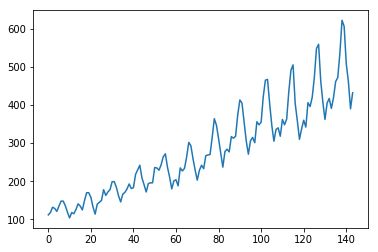

In [29]:
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')
plot(ts); 

144


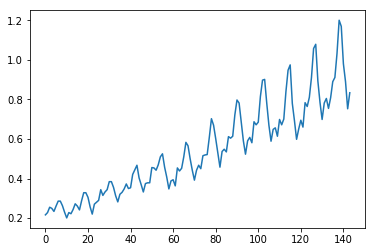

In [30]:
# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
ts = list(map(lambda x: x / scalar, ts))
print(len(ts))
plot(ts); 

In [48]:
# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(ts)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

[[0.21621622]
 [0.22779922]] [0.25482625]


In [53]:
# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

(99, 2, 1) (99, 1)


In [54]:
# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)
print(train_x.shape,train_y.shape)

torch.Size([99, 1, 2]) torch.Size([99, 1, 1])


In [55]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [56]:
net = lstm_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [57]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


Epoch: 100, Loss: 0.00431
Epoch: 200, Loss: 0.00379
Epoch: 300, Loss: 0.00355
Epoch: 400, Loss: 0.00448
Epoch: 500, Loss: 0.00221
Epoch: 600, Loss: 0.00176
Epoch: 700, Loss: 0.00153
Epoch: 800, Loss: 0.00136
Epoch: 900, Loss: 0.00133
Epoch: 1000, Loss: 0.00108


torch.Size([142, 1, 1]) (142,) 144


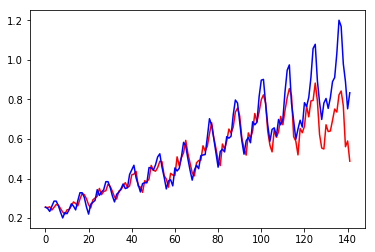

In [59]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

### Although RNN predicts the time series well in the training set (see below), the predictions fail in the test set

torch.Size([99, 1, 1]) (99,) 144


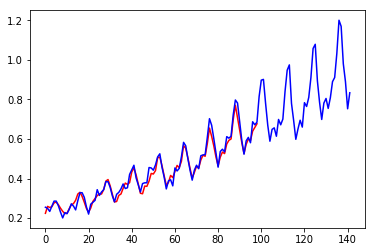

In [172]:
# Testing on the train series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = train_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

### The reason why this happens could be attributed to an extrapolation problem

To address this point, I plot (Xt-1, Xt-2) for training and testing data below. It shows that they have little overlapping, which means that what the RNN needs to do is to predict Xt using the context (Xt-1, Xt-2) that it has never seen before. It turns out RNN fails to do this well. I will show later that if the context (Xt-1, Xt-2) in the training and testing data set are similar, the RNN can do it pretty well. 




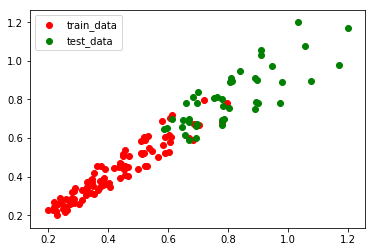

In [82]:
plot_train_x_X_t_1 = [[i[0][0]] for i in train_X]
plot_train_x_X_t_0 = [[i[0][1]] for i in train_X]
plot_test_x_X_t_1 = [[i[0][0]] for i in test_X]
plot_test_x_X_t_0 = [[i[0][1]] for i in test_X]


scatter(plot_train_x_X_t_1,plot_train_x_X_t_0, c='r',label = "train_data")
scatter(plot_test_x_X_t_1,plot_test_x_X_t_0, c='g',label = "test_data")
legend()

### 2.2 Use CNN to predict the time series

In [83]:
print(data_X.shape, data_Y.shape) # (seq, feature, batch)

(142, 2, 1) (142, 1)


In [84]:
# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)

torch.Size([99, 1, 2]) torch.Size([99, 1])


In [85]:
class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size):
        super(cnn_reg, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features

        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x=x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x

In [86]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [87]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


Epoch: 100, Loss: 0.00290
Epoch: 200, Loss: 0.00265
Epoch: 300, Loss: 0.00253
Epoch: 400, Loss: 0.00241
Epoch: 500, Loss: 0.00228
Epoch: 600, Loss: 0.00217
Epoch: 700, Loss: 0.00207
Epoch: 800, Loss: 0.00199
Epoch: 900, Loss: 0.00194
Epoch: 1000, Loss: 0.00192


torch.Size([142, 1]) (142,) 144


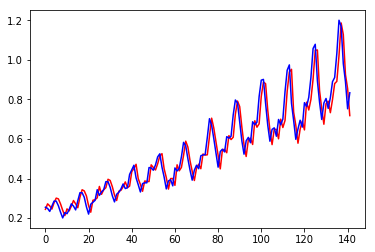

In [88]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

### The reason why the CNN can predict the time series so well: the data structure and the kernel-based learning

In [96]:
ts_all = pd.read_csv('data.csv')
ts_all.head(12)

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
5,1949-06,135.0
6,1949-07,148.0
7,1949-08,148.0
8,1949-09,136.0
9,1949-10,119.0


#### The data has a periodic nature (year by year, and 12 data points per year), with an upward trend. For a CNN, what it needs to learn is at most 12 kernels, each knowing how to map the data in the previous two months to the data in the current month. 

#### The potential 12 kernels are: (Jan, Feb) -> (Mar), (Feb, Mar)-> (April), ... (Dec, Jan) -> (Feb)

#### And the hidden layer size is 10, which is comparable to the number of potential kernels. Therefore, CNN can conquer this problem really well. 








In [98]:
print(net)
for name, param in net.named_parameters(): # Iterate over parameters
                print(name,param) 

cnn_reg(
  (conv): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
  (reg): Linear(in_features=10, out_features=1, bias=True)
)
conv.weight Parameter containing:
tensor([[[ 5.1231e-01,  5.3415e-01]],

        [[ 1.2263e-05,  9.5407e-02]],

        [[-5.4680e-01,  7.9645e-01]],

        [[-3.0237e-01, -9.7690e-01]],

        [[ 6.9882e-01,  6.3882e-01]],

        [[ 1.5679e-01,  2.0842e-01]],

        [[-4.5080e-01,  5.2785e-01]],

        [[-5.9019e-01,  2.8216e-01]],

        [[ 4.1500e-01, -4.3038e-02]],

        [[-3.3789e-01,  1.1485e+00]]])
conv.bias Parameter containing:
tensor([ 0.5033, -0.0339, -0.1443, -0.0845, -0.4747,  0.4173, -0.2835,
        -0.3059, -0.5167, -0.2590])
reg.weight Parameter containing:
tensor([[ 0.1742, -0.0628,  0.1324, -0.4839, -0.0473, -0.0041,  0.1114,
          0.1339, -0.1050,  0.3123]])
reg.bias Parameter containing:
tensor(1.00000e-03 *
       [-6.0023])


### All about data: another example where RNN performs well, but CNN fails. 

#### This example is a non-linear time series: X_t = 3.8* X_(t-1)* (1-X-(t-1)), X_0=0.5

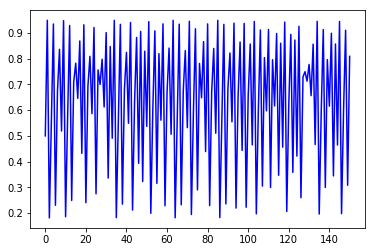

In [107]:
x=[0.5] # equal possibility
x1_history=[x[0]]
dt=1; 
for t in np.arange(0,150,dt):
    x[0]=3.8*x[0]*(1-x[0]);
    x1_history.append(x[0])
plot(x1_history,'b')

In [108]:
x1_history = [np.array([i], dtype='float32') for i in x1_history]
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim

### 2.3 RNN predict the time series really well

In [109]:
data_X, data_Y = create_dataset(x1_history)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape)

[[0.5 ]
 [0.95]] [0.1805]
(104, 2, 1) (104, 1)
torch.Size([104, 1, 2]) torch.Size([104, 1, 1])


In [110]:
net = lstm_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [111]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


Epoch: 100, Loss: 0.06344
Epoch: 200, Loss: 0.00231
Epoch: 300, Loss: 0.00075
Epoch: 400, Loss: 0.00036
Epoch: 500, Loss: 0.00017
Epoch: 600, Loss: 0.00007
Epoch: 700, Loss: 0.00003
Epoch: 800, Loss: 0.00002
Epoch: 900, Loss: 0.00007
Epoch: 1000, Loss: 0.00001


torch.Size([149, 1, 1]) (149,) 144


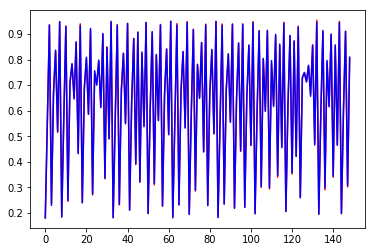

In [112]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(x1_history[2:], 'b', label='real');

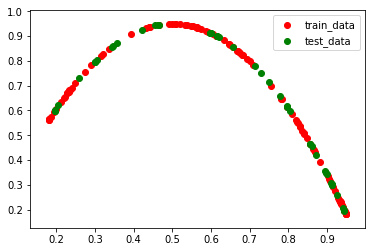

In [113]:
plot_train_x_X_t_1 = [[i[0][0]] for i in train_X]
plot_train_x_X_t_0 = [[i[0][1]] for i in train_X]
plot_test_x_X_t_1 = [[i[0][0]] for i in test_X]
plot_test_x_X_t_0 = [[i[0][1]] for i in test_X]


scatter(plot_train_x_X_t_1,plot_train_x_X_t_0, c='r',label = "train_data")
scatter(plot_test_x_X_t_1,plot_test_x_X_t_0, c='g',label = "test_data")
legend()

#### We can observe that the (Xt-1, Xt-2) for training and testing data are in the same set, which gurantees the RNN to perform well <br>
#### But, how about CNN?


### 2.4 CNN fails to predict the time series well

In [114]:
# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)

torch.Size([104, 1, 2]) torch.Size([104, 1])


In [115]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [116]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


Epoch: 100, Loss: 0.04290
Epoch: 200, Loss: 0.03630
Epoch: 300, Loss: 0.03628
Epoch: 400, Loss: 0.03628
Epoch: 500, Loss: 0.03628
Epoch: 600, Loss: 0.03628
Epoch: 700, Loss: 0.03628
Epoch: 800, Loss: 0.03628
Epoch: 900, Loss: 0.03628
Epoch: 1000, Loss: 0.03628


torch.Size([149, 1]) (149,) 144


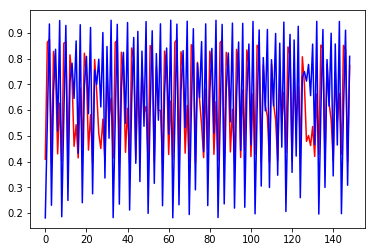

In [117]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(x1_history[2:], 'b', label='real');

#### CNN fails to predict the time series, even in the training epochs. This implies CNN can perform well, even better than RNN in predicting time series, but only in specidic types of data structure. For non-linear time series as the example addresses, with no explicit periodic structures or specific-patterns, kernel-based CNN could fail. 